# Training Notebook #
This notebook will be used to test training of neural networks using pytorch

In [1]:
import torch, os, random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from PIL import Image, ImageDraw
from IPython.display import display

Device check

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using ", end="")
print(device)

Using cuda


## Dataset ##
Download dataset and stuff

In [3]:
class RisikoDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir:str, mode:str, transform=None):
        if mode != "train" and mode != "val" and mode != "test":
            raise Exception("Mode value of dataset not valid")

        self.imgs_dir = dataset_dir + "/" + mode + "/images"
        self.annots_dir = dataset_dir + "/" + mode + "/labels"

        self.annotations = sorted( filter( lambda x: os.path.isfile(os.path.join(self.annots_dir, x)), os.listdir(self.annots_dir) ) )
        self.images = sorted( filter( lambda x: os.path.isfile(os.path.join(self.imgs_dir, x)), os.listdir(self.imgs_dir) ) )
        self.transform = transform

        if len(self.annotations) != len(self.images):
            raise Exception("Number of annotations is different from the number of images")

        for i in range(len(self.annotations)):
            if os.path.splitext(os.path.basename(self.annotations[i]))[0] != os.path.splitext(os.path.basename(self.images[i]))[0]:
                raise Exception("Mismatch between images and annotations at id " + str(i) + ".   imgName = " + os.path.splitext(os.path.basename(self.images[i]))[0] + "   labelName = " + os.path.splitext(os.path.basename(self.annotations[i]))[0])
    
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self, idx:int) -> tuple[torch.Tensor, dict]:
        annotations_file_data = np.genfromtxt(fname= self.annots_dir + "/" + self.annotations[idx], delimiter=' ', dtype=np.float32)
        classes, bboxes = np.hsplit(annotations_file_data, np.array([1]))

        output_dict = {} 
        output_dict["boxes"] = torch.from_numpy(bboxes)
        output_dict["labels"] = torch.from_numpy(classes).type(torch.IntTensor)
        
        img = Image.open(self.imgs_dir + "/" + self.images[idx]).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, output_dict


In [4]:
img_to_tensor = transforms.Compose([
    #transforms.Resize(size=(500,500)),
    transforms.PILToTensor()
])

batch_size = 50

dataset_path = "./data/risiko_dataset"

train_set = RisikoDataset(dataset_dir=dataset_path, mode="train", transform=img_to_tensor)
val_set = RisikoDataset(dataset_dir=dataset_path, mode="val", transform=img_to_tensor)
test_set = RisikoDataset(dataset_dir=dataset_path, mode="test", transform=img_to_tensor)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

## Check dataset ##
Print random image with bouding box to be sure that everything is working correctly

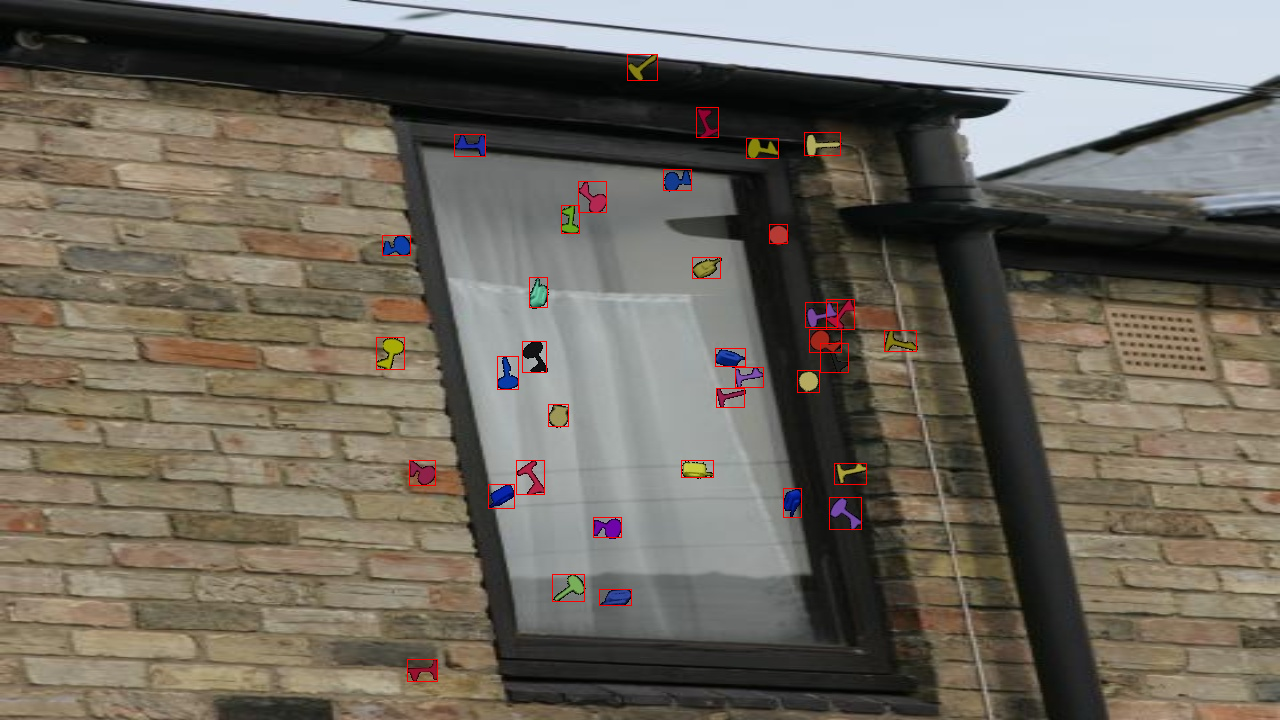

In [12]:
def draw_bboxes_on_image(dataset: RisikoDataset, index:int):
    img, labels = dataset.__getitem__(index)
    tensor_to_img = transforms.Compose([transforms.ToPILImage()])
    img = tensor_to_img(img)
    bboxes: torch.Tensor = labels["boxes"]

    img_draw = ImageDraw.Draw(img)
    bboxes = bboxes * torch.tensor([1280,720,1280,720])

    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]

        x0 = bbox[0] - bbox[2] / 2
        x1 = bbox[0] + bbox[2] / 2
        y0 = bbox[1] - bbox[3] / 2
        y1 = bbox[1] + bbox[3] / 2

        img_draw.rectangle([x0, y0, x1, y1], outline="red")
    
    display(img)


draw_bboxes_on_image(train_set, random.randint(0, len(train_set)-1))


## Neural Network ##
Definition of the Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

## Loss Function and Optimizer ##


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training ##

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')